In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
from new_Adam import *
import no_gpu
import reproducible

In [4]:
import time

In [5]:
X_train, X_val, y_train, y_val = mnist_prep()

In [6]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 0s 150us/sample - loss: 2.1632 - accuracy: 0.2590 - val_loss: 1.8865 - val_accuracy: 0.4000
Epoch 2/5
1000/1000 [==============================] - 0s 85us/sample - loss: 1.5317 - accuracy: 0.5710 - val_loss: 1.3159 - val_accuracy: 0.6200
Epoch 3/5
1000/1000 [==============================] - 0s 85us/sample - loss: 0.9112 - accuracy: 0.7840 - val_loss: 0.8003 - val_accuracy: 0.7800
Epoch 4/5
1000/1000 [==============================] - 0s 85us/sample - loss: 0.4592 - accuracy: 0.8880 - val_loss: 0.5733 - val_accuracy: 0.8220
Epoch 5/5
1000/1000 [==============================] - 0s 85us/sample - loss: 0.2412 - accuracy: 0.9300 - val_loss: 0.4890 - val_accuracy: 0.8480
Overall calculation took 1.5668790340423584 seconds.
Model: "sequential"
_________________________________________________________________
La

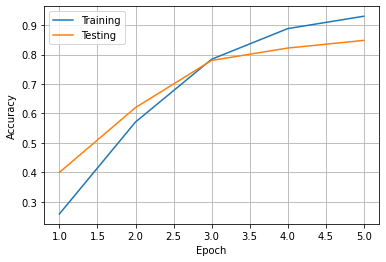

In [7]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                         optimizer = Adam_test())
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 100,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")

In [8]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(128, 128) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(128, 64) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(64, 32) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'dense_4/kernel:0' shape=(32, 10) dtype=float32>,
 <tf.Variable 'dense_4/bias:0' shape=(10,) dtype=float32>]

In [9]:
model.history.history

{'loss': [2.1632373571395873,
  1.5317402958869935,
  0.9111589133739472,
  0.4591607689857483,
  0.24115796387195587],
 'accuracy': [0.259, 0.571, 0.784, 0.888, 0.93],
 'val_loss': [1.8865085124969483,
  1.3158961296081544,
  0.800297212600708,
  0.5733006358146667,
  0.4889929473400116],
 'val_accuracy': [0.4, 0.62, 0.78, 0.822, 0.848]}

In [10]:
model.evaluate(X_val_small, y_val_small)

[0.48899293422698975, 0.848]

In [11]:
model.output

<tf.Tensor 'dense_4/Softmax:0' shape=(None, 10) dtype=float32>

In [12]:
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

[array([[ 0.04038461, -0.01594737, -0.0924079 , ..., -0.052815  ,
        -0.00175327,  0.04860573],
       [-0.07242333,  0.02819264,  0.09996936, ...,  0.02712767,
        -0.0631801 , -0.08813966],
       [-0.0023563 , -0.08987392, -0.03038354, ..., -0.01370368,
         0.0033496 ,  0.04424093],
       ...,
       [ 0.03823195,  0.07148312, -0.08017713, ...,  0.06832674,
        -0.01672177,  0.03934802],
       [-0.03099382, -0.04149559, -0.00190553, ...,  0.05527242,
         0.0424802 ,  0.02808379],
       [ 0.01023323, -0.00405132,  0.04394671, ..., -0.04591167,
        -0.06593745, -0.01768338]], dtype=float32), array([ 0.042806  ,  0.12557082, -0.19098462,  0.02862359,  0.11317403,
       -0.1037174 ,  0.03621542,  0.00998835,  0.14683993, -0.02868482,
        0.20167522, -0.04032132, -0.11320678,  0.02664861, -0.02228425,
       -0.02766774,  0.0874148 ,  0.06334495, -0.06988158, -0.0929606 ,
        0.12205198,  0.16668965,  0.07000992,  0.08801751,  0.15028983,
        0.

In [13]:
weights = model.get_weights()
print(weights)

[array([[ 0.04038461, -0.01594737, -0.0924079 , ..., -0.052815  ,
        -0.00175327,  0.04860573],
       [-0.07242333,  0.02819264,  0.09996936, ...,  0.02712767,
        -0.0631801 , -0.08813966],
       [-0.0023563 , -0.08987392, -0.03038354, ..., -0.01370368,
         0.0033496 ,  0.04424093],
       ...,
       [ 0.03823195,  0.07148312, -0.08017713, ...,  0.06832674,
        -0.01672177,  0.03934802],
       [-0.03099382, -0.04149559, -0.00190553, ...,  0.05527242,
         0.0424802 ,  0.02808379],
       [ 0.01023323, -0.00405132,  0.04394671, ..., -0.04591167,
        -0.06593745, -0.01768338]], dtype=float32), array([ 0.042806  ,  0.12557082, -0.19098462,  0.02862359,  0.11317403,
       -0.1037174 ,  0.03621542,  0.00998835,  0.14683993, -0.02868482,
        0.20167522, -0.04032132, -0.11320678,  0.02664861, -0.02228425,
       -0.02766774,  0.0874148 ,  0.06334495, -0.06988158, -0.0929606 ,
        0.12205198,  0.16668965,  0.07000992,  0.08801751,  0.15028983,
        0.

In [14]:
y_true, y_pred = nn_class_pred_true(model, X_val_small, y_val_small, print_comp = True)

Prediction: 2, Actual: 6, False
Prediction: 9, Actual: 9, True
Prediction: 5, Actual: 8, False
Prediction: 5, Actual: 5, True
Prediction: 9, Actual: 9, True
Prediction: 9, Actual: 9, True
Prediction: 7, Actual: 7, True
Prediction: 9, Actual: 9, True
Prediction: 3, Actual: 3, True
Prediction: 2, Actual: 2, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 1, Actual: 1, True
Prediction: 5, Actual: 5, True
Prediction: 6, Actual: 6, True
Prediction: 9, Actual: 9, True
Prediction: 8, Actual: 8, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 4, Actual: 4, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 7, Actual: 9, False
Prediction: 9, Actual: 9, True
Prediction: 5, Actual: 5, True
Prediction: 4, Actual: 4, True
Prediction: 9, Actual: 7, False
Prediction: 1, Actual: 1, True
Prediction: 5, Actual: 5, True
Prediction: 5, Actual: 5, True
Prediction: 8, Actual: 8, True
Prediction: 9, Actual: 9, True
Pred

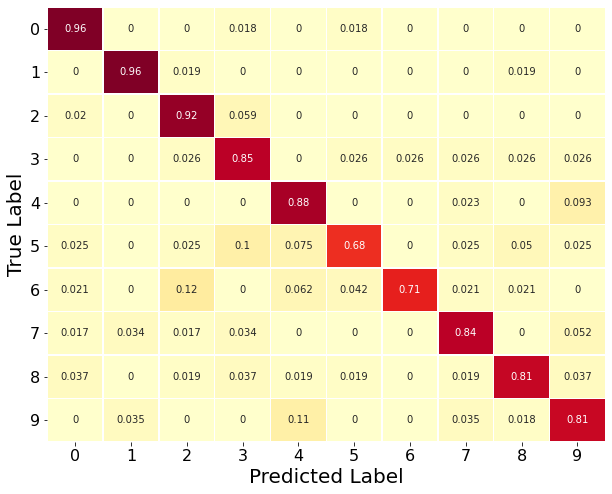

In [15]:
cm = nn_conf_mat(y_true, y_pred)

In [16]:
cm

array([[0.96428571, 0.        , 0.        , 0.01785714, 0.        ,
        0.01785714, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.96296296, 0.01851852, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01851852, 0.        ],
       [0.01960784, 0.        , 0.92156863, 0.05882353, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.02564103, 0.84615385, 0.        ,
        0.02564103, 0.02564103, 0.02564103, 0.02564103, 0.02564103],
       [0.        , 0.        , 0.        , 0.        , 0.88372093,
        0.        , 0.        , 0.02325581, 0.        , 0.09302326],
       [0.025     , 0.        , 0.025     , 0.1       , 0.075     ,
        0.675     , 0.        , 0.025     , 0.05      , 0.025     ],
       [0.02083333, 0.        , 0.125     , 0.        , 0.0625    ,
        0.04166667, 0.70833333, 0.02083333, 0.02083333, 0.        ],
       [0.01724138, 0.03448276, 0.0172413

In [17]:
true_acc = model.evaluate(X_val_small, y_val_small)[1]
print(true_acc)

shape_0 = model.get_weights()[0].shape
print(shape_0)

old_first_weights = model.get_weights()[0]

# first_weights = [np.random.normal(size = shape_0)]
first_weights = [model.get_weights()[0]-1]
print(first_weights)
print(first_weights[0].shape)

all_weights = first_weights + model.get_weights()[1:]
# print(all_weights)

model.set_weights(all_weights)

fake_acc = model.evaluate(X_val_small, y_val_small)[1]
print(fake_acc)

old_weights = [old_first_weights] + model.get_weights()[1:]

model.set_weights(old_weights)

old_true_acc = model.evaluate(X_val_small, y_val_small)[1]
print(old_true_acc)

0.848
(784, 128)
[array([[-0.9596154 , -1.0159473 , -1.092408  , ..., -1.052815  ,
        -1.0017532 , -0.95139426],
       [-1.0724233 , -0.97180736, -0.9000306 , ..., -0.9728723 ,
        -1.0631801 , -1.0881397 ],
       [-1.0023563 , -1.0898739 , -1.0303836 , ..., -1.0137037 ,
        -0.9966504 , -0.95575905],
       ...,
       [-0.96176803, -0.92851686, -1.0801771 , ..., -0.9316733 ,
        -1.0167217 , -0.960652  ],
       [-1.0309938 , -1.0414956 , -1.0019056 , ..., -0.9447276 ,
        -0.95751977, -0.9719162 ],
       [-0.9897668 , -1.0040513 , -0.9560533 , ..., -1.0459117 ,
        -1.0659374 , -1.0176834 ]], dtype=float32)]
(784, 128)
0.124
0.848
